In [401]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [422]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from mpl_toolkits import mplot3d
import math
import corner

In [403]:
# p: parametros [m,b], x: datos
# funcion lineal

def linea(p,x):
    r = p[0]*x+p[1]
    return r

def lnlike(p,x):
    lnL=-(x[1]-linea(p,x[0]))**2/(2*x[2]**2)-np.log(2*np.pi*x[2]**2)
    return lnL.sum()


# ----------------------------------------------------------
def prim(m,Pm=0):

    if minm < m and maxm > m:
        return Pm
    else:
        return 0


def prib(b,Pb=0):

    if minb < b and maxb > b:
        return Pb
    else:
        return 0


def pos(p,x,Pm,Pb):
    
    ln_like=lnlike(p,x)
    ln_prior=np.log(prib(p[1],Pb)*prim(p[0],Pm))
    z=ln_like+ln_prior
    return z

In [404]:
db = np.load('fit_exercise.npy')
# plt.plot(db[0],db[1],'.')

In [405]:
# O: punto inicial [m,b],    x:datos [x,y,err_y]    s:numero de pasos
def metro(O,x,s):
# ----------------------------------------------------

# guardar los datos
    h=np.zeros([s+1,2])

# sigma para los datos aleatorios
    sig =0.2

# calculo de postirior
    posn_v=np.zeros(s+1)
    posv=pos(h[0],db,Pm,Pb)
    
# ------------------------------------------------    
    a=[]
    b=[]

#     count=0
#     count1= 0

# punto de inicio, p=[m,b]
    m0=O[0]
    b0=O[1]
    h[0]=O
    posv=pos(h[0],db,Pm,Pb)

    for i in range(s):

        m1= (np.random.normal(m0,sig,1))
        b1= (np.random.normal(b0,sig,1))
    
        posn = pos([m1,b1],db,Pm,Pb)
        h[i+1]=[m1,b1]
    
        posn_v [i]= posn-posv
      
        if posn > posv*1: 
            posv = np.copy(posn)
            m0 = np.copy(m1)
            b0 = np.copy(b1)
#             count = count+1
            a.append(m1[0])
            b.append(b1[0])
        
        elif posn_v[i] > np.log(np.random.rand()):
            posv = np.copy(posn)
            m0 = np.copy(m1)
            b0 = np.copy(b1)
#             count1 = count1+1
            a.append(m0[0])
            b.append(b0[0])
            
    z=[h,a,b]
#     print(count)
#     print(count1)
#     plt.plot(h[:,0],h[:,1],'.')
#     plt.plot(a,b,'r.')
#     plt.xlabel('m')
#     plt.ylabel('b')
#     plt.show()
            
    return  z       

In [406]:
# x:datos, s:pasos, k:numero de iteraciones
def walk(O,x,s,k):
    
    metr=[]
    
    for i in range(k):
        m0= (np.random.normal(O[0],1,1))
        b0= (np.random.normal(O[1],1,1))
        O1=[m0,b0]
        metr.append(metro(O1,db,s))
    
    return metr    

In [407]:
# var: varianza [m,b],   mean: promedios [m,b],   k: walkers,   s: pasos,   metr: informacion
def GeRi(k,s,metr):
    
    var= np.zeros((k,2))
    mean= np.zeros((k,2))
    
    for i in range(k):

        var[i,0]=np.var(metr[i][0][:,0], ddof=1)
        var[i,1]=np.var(metr[i][0][:,1], ddof=1)
        mean[i]=np.array([np.mean(metr[i][0][:,0]),np.mean(metr[i][0][:,1])])
    
    
    if k==1:
        return 0
    else:
        S2=[np.square(var[:,0]).sum()/k,np.square(var[:,1]).sum()/k]
        B_n=[np.var(mean[:,0], ddof=1),np.var(mean[:,1], ddof=1)]
        Sig2=[(s-1)*S2[0]/s  +B_n[0],(s-1)*S2[1]/s  +B_n[1]]
        R=np.sqrt(np.divide(Sig2,S2))
    return R

In [417]:
m0=-0.9 #h[0,0]
b0=4.8 #h[0,1]

O=[m0,b0]
s=3000
k=3

minm=-2
maxm=2
Pm=1/(maxm-minm)

minb=-10
maxb=10
Pb=1/(maxb-minb)

In [418]:
# La variable metr contiene la información de los k walkers
# metr[i][j]=> i:numero de walker, j: atributo(0: todos los pasos [m,b],   1: m acemptados,   2: b aceptdos)
metr=walk(O,db,s,k);

C:\Users\Miguel\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log
C:\Users\Miguel\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


In [421]:
# si GeRi>1 puede que el valor converja
GeRi(k,s,metr)

array([1.02553364, 1.0970686 ])

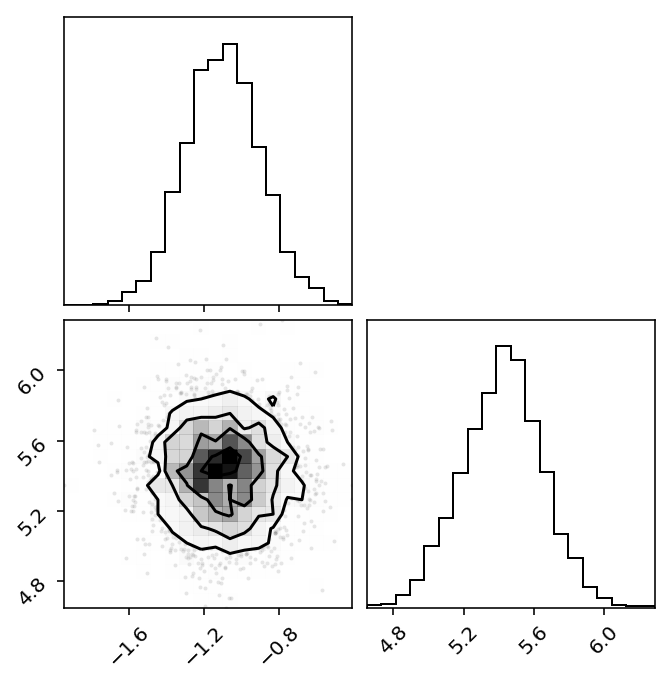

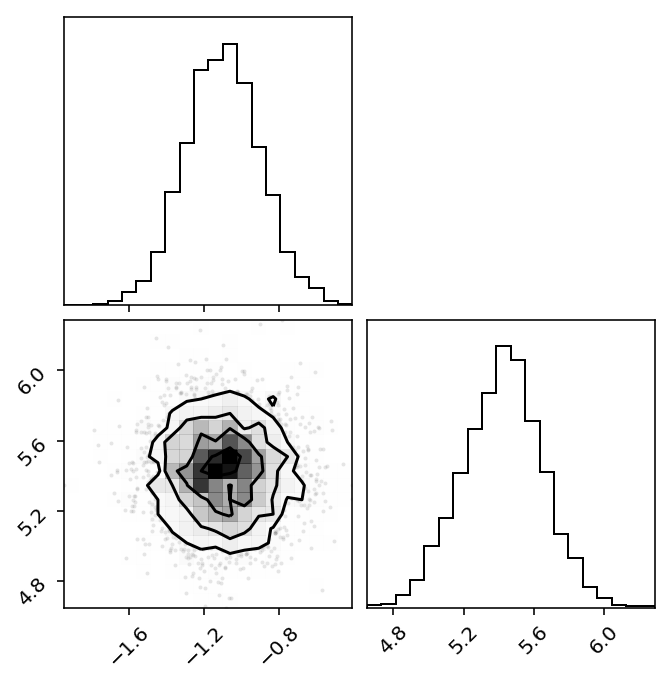

In [429]:
corner.corner(metr[1][0])

In [430]:
# Show plots inline, and load main getdist plot module and samples class
from __future__ import print_function
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
from getdist import plots, MCSamples
import getdist
# use this *after* importing getdist if you want to use interactive plots
# %matplotlib notebook
import matplotlib.pyplot as plt
import IPython
print('GetDist Version: %s, Matplotlib version: %s'%(getdist.__version__, plt.matplotlib.__version__))
# matplotlib 2 may not work very well without usetex on, can uncomment
# plt.rcParams['text.usetex']=True

GetDist Version: 1.1.2, Matplotlib version: 2.2.2


In [468]:
# Get some random samples for demonstration:
# make random covariance, then independent samples from Gaussian
ndim = k*2
np.random.seed(10)
A = np.random.rand(ndim,ndim)
cov = np.dot(A, A.T)


samps=metr[0][0]
for i in range(1,k):
    samps=np.c_[ samps, metr[i][0]]



In [469]:
# Get the getdist MCSamples objects for the samples, specifying same parameter
# names and labels; if not specified weights are assumed to all be unity
names = ["p%s"%i for i in range(ndim)]
labels =  ["p_%s"%i for i in range(ndim)]
samples = MCSamples(samples=samps,names = names, labels = labels)


Removed no burn in


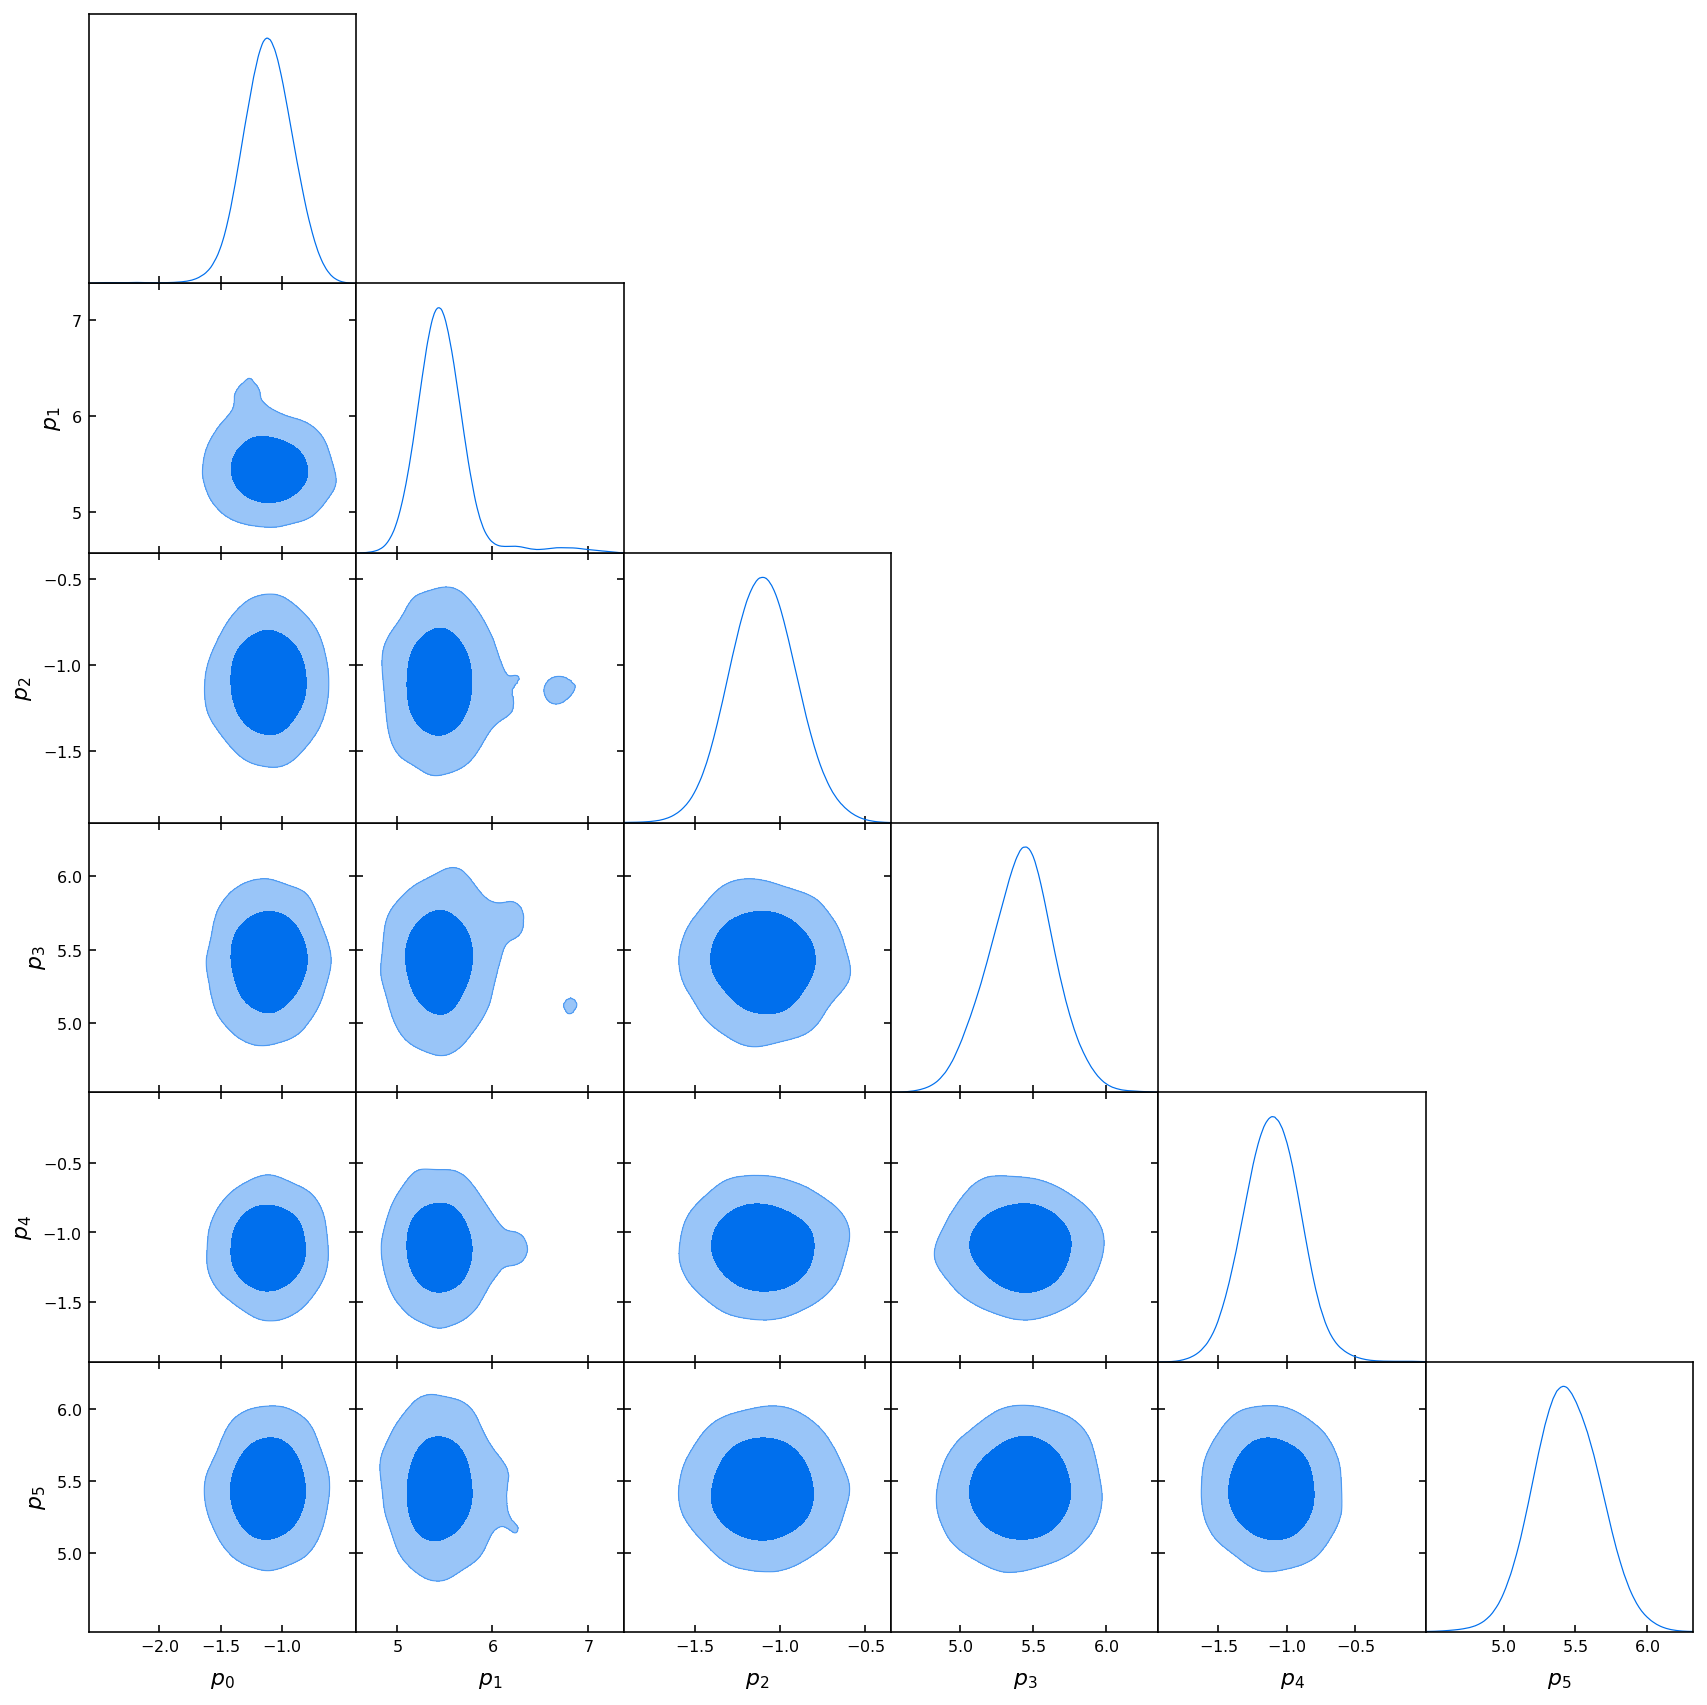

In [470]:
# Triangle plot
g = plots.get_subplot_plotter()
g.triangle_plot([samples], filled=True)